In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from plotly import graph_objects as go
import seaborn as sns
import matplotlib.gridspec as gridspec

#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('gym.csv')

## Предобработка данных

In [3]:
data = data.drop('Unnamed: 0', axis=1)

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
Gender                               4000 non-null int64
Near_location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Age                                  4000 non-null int64
Lifetime                             4000 non-null int64
Contract_period                      4000 non-null int64
Month_to_end_contract                4000 non-null int64
Group_visits                         4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Avg_additional_charges_total         4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


,Gender,Near_location,Partner,Promo_friends,Phone,Age,Lifetime,Contract_period,Month_to_end_contract,Group_visits,Avg_class_frequency_total,Avg_class_frequency_current_month,Avg_additional_charges_total,Churn
0,1,1,1,1,0,29,3,6,5,1,0.020398,0.000000,14.227470,0
1,0,1,0,0,1,31,7,12,12,1,1.922936,1.910244,113.202938,0
2,0,1,1,0,1,28,2,1,1,0,1.859098,1.736502,129.448479,0
3,0,1,1,1,1,33,2,12,12,1,3.205633,3.357215,62.669863,0
4,1,1,1,1,1,26,3,1,1,0,1.113884,1.120078,198.362265,0


In [5]:
list(data.columns.values)

['Gender',
 'Near_location',
 'Partner',
 'Promo_friends',
 'Phone',
 'Age',
 'Lifetime',
 'Contract_period',
 'Month_to_end_contract',
 'Group_visits',
 'Avg_class_frequency_total',
 'Avg_class_frequency_current_month',
 'Avg_additional_charges_total',
 'Churn']

In [6]:
data.rename(columns={'gender':'Gender', 'Near_Location':'Near_location'}, inplace=True)

In [7]:
#Решила расположить столбцы в порядке, как перечислено в задании по проекту
data = data[['Gender', 'Near_location', 'Partner', 'Promo_friends', 'Phone', 'Age',\
             'Lifetime', 'Contract_period', 'Month_to_end_contract', 'Group_visits', 'Avg_class_frequency_total',\
             'Avg_class_frequency_current_month', 'Avg_additional_charges_total', 'Churn']]

In [8]:
data['Month_to_end_contract'] = data['Month_to_end_contract'].astype('int')

In [9]:
data.duplicated().sum()

0

In [10]:
data.isnull().sum()

Gender                               0
Near_location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Age                                  0
Lifetime                             0
Contract_period                      0
Month_to_end_contract                0
Group_visits                         0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Avg_additional_charges_total         0
Churn                                0
dtype: int64

## Исследовательский анализ данных

In [11]:
data[['Age', 'Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_total', \
      'Avg_class_frequency_current_month', 'Avg_additional_charges_total']].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
Lifetime,4000.0,3.72,3.75,0.00,1.00,3.00,5.00,31.00
Contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
Month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00
Avg_class_frequency_total,4000.0,1.88,0.97,0.00,1.18,1.83,2.54,6.02
Avg_class_frequency_current_month,4000.0,1.77,1.05,0.00,0.96,1.72,2.51,6.15
Avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59


__Портрет пользователя сети фитнес-центров (ФЦ):__  
- __Средний возраст__ клиента составляет 29 лет, причем медиана практически равна среднему, то есть возраст распределен относительно среднего значения равномерно. Стоит отметить также, что разброс этой характеристики небольшой, ФЦ пользуются молодые клиенты возрастом от 18 до 41 года.  
- __Средний срок__ пользования услугами ФЦ - три месяца, четвертая часть клиентов посещает его 1-й месяц,  но некоторые пользуются услугами сети более двух лет. Таким образом, стоит отметить, что средний срок - низкий, одной из задач ФЦ должно быть удержание существующих клиентов.  
- Половина пользователей покупают __абонемент только на один месяц__, и только четверть - на 6 месяцев и более.  
- __Средний срок до окончания контракта__ - один месяц, что связано с длительностью самого популярного контракта.  
- __Средняя частота посещений в неделю за все время контракта__ - почти два занятия, 25% пользователей ходят в ФЦ более 2 раз в неделю.  
- __Средняя частота посещений в неделю за последний месяц__ - несколько ниже, чем показатель за все время пользования. Это не очень хороший знак, но следовало бы посмотреть среднюю частоту посещений по месяцам (и, желательно, по когоротам), чтобы понять, является ли это колебанием вокруг среднего значения или тенденцией к снижению посещаемости.  
- В среднем клиенты приносят 147 у.е. __дополнительной выручки__, но половина клиентов приносит 136 и меньше, среднее выше медианы за счет единичных клиентов, которые тратили существенно больше.



Мы __проанализируем отдельно категориальные и количественные показатели.__
Для удобства построения графиков, мы сгруппируем данные по полу и данные по другим признакам отдельно.


### Категориальные признаки

In [12]:
category_data = data[['Churn', 'Gender', 'Near_location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']]

In [13]:
# Для удобства дальнейшей характеристики обозначим группу тех, кто продолжает пользоваться услугами ФЦ как "клиенты",
# группу тех, кто ушел в отток - "неклиенты".
gender_map = {0:'клиенты', 1:'неклиенты'}
category_data['Churn'] = category_data['Churn'].map(gender_map)

C:\Users\laris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [14]:
# В таблице по полу мы выделим столбцы "женщины" / "мужчины", 
# а в строках укажем количество людей каждого пола в группах "клиенты" / "неклиенты"
gender_grouped = category_data.groupby('Churn').agg({'Gender':'value_counts'}).unstack(level=1).reset_index()
gender_grouped.columns = ['Churn', 'Gender_0', 'Gender_1']
gender_grouped

,Churn,Gender_0,Gender_1
0,клиенты,1440,1499
1,неклиенты,519,542


In [15]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=gender_grouped['Churn'],
    x=gender_grouped['Gender_0'],
    name='женщины', marker_color='#FF69B4',
    orientation='h'
   )
    )
fig.add_trace(go.Bar(
    y=gender_grouped['Churn'],
    x=gender_grouped['Gender_1'],
    name='мужчины', marker_color='#87CEFA', orientation='h')
    
    )

fig.update_layout(
    barmode='stack', 
    title_text = 'Половой состав групп', 
    autosize=False, width=600, height=300)
fig.update_xaxes(title_text='Группы')
fig.show()


На графике мы видим, что:  
- в группе "клиенты" почти в три раза больше человек (ок. 3000), чем в группе "неклиенты", хотя отток на уровне 30% - это много;  
- в ФЦ сети ходит одинаковое количество мужчин и женщин, а также то, что отток свойственнен тем и другим в равной степени. 

Я хотела бы посмотреть, __отличаются ли характеристики признаков для мужчин и женщин,__ чтобы понимать, нужно ли добавлять индикатор пола на графики.

In [16]:
men = data[data['Gender']==1].pivot_table(index=['Churn'], aggfunc='mean')
women = data[data['Gender']==0].pivot_table(index=['Churn'], aggfunc='mean')
gender_comp = men/women
gender_comp

,Age,Avg_additional_charges_total,Avg_class_frequency_current_month,Avg_class_frequency_total,Contract_period,Gender,Group_visits,Lifetime,Month_to_end_contract,Near_location,Partner,Phone,Promo_friends
Churn,,,,,,,,,,,,,
0,1.002966,0.983076,1.017753,1.018967,0.995263,inf,1.033749,1.032012,0.991698,1.003506,0.968011,0.994502,0.992599
1,1.003727,1.007089,0.977465,1.002112,1.061026,inf,1.094360,0.981550,1.055718,1.013181,1.025962,0.994237,0.947794


В целом, __соотношение мужчин и женщин__ в группах клиенты/неклиенты примерно равно 1, разница не превышает 6%, поэтому мы не будем учитывать характеристику пола при анализе остальных характеристик клиентов.

На графике выше мы показали __количество человек в группах "клиенты" / "неклиенты"__, и __остальные признаки в этих группах будем сравнивать в долях__ для большей наглядности.
Поэтому я сгруппирую клиентов / неклиентов по столбцам для каждого признака. В строках укажу отсутствие/наличие признака для каждой группы.

In [17]:
category_data_grouped = category_data.groupby('Churn').agg(
    {'Near_location':'value_counts', 'Partner':'value_counts', 'Promo_friends':'value_counts',\
      'Phone':'value_counts', 'Group_visits':'value_counts'})
category_data_grouped = category_data_grouped.unstack(level=0).reset_index()

In [18]:
category_data_grouped.columns = ['Feature', 'Near_location_in_0', 'Near_location_in_1',\
                                   'Partner_in_0', 'Partner_in_1', 'Promo_friends_in_0', 'Promo_friends_in_1',\
                                   'Phone_in_0', 'Phone_in_1', 'Group_visits_in_0', 'Group_visits_in_1']
#feature_map - столбец, где указано отсутствие / наличие какого-либо признака
feature_map = {0:'нет', 1:'да'}
category_data_grouped['Feature'] = category_data_grouped['Feature'].map(feature_map)
category_data_grouped

,Feature,Near_location_in_0,Near_location_in_1,Partner_in_0,Partner_in_1,Promo_friends_in_0,Promo_friends_in_1,Phone_in_0,Phone_in_1,Group_visits_in_0,Group_visits_in_1
0,нет,373,246,1369,684,1900,866,283,103,1575,776
1,да,2566,815,1570,377,1039,195,2656,958,1364,285


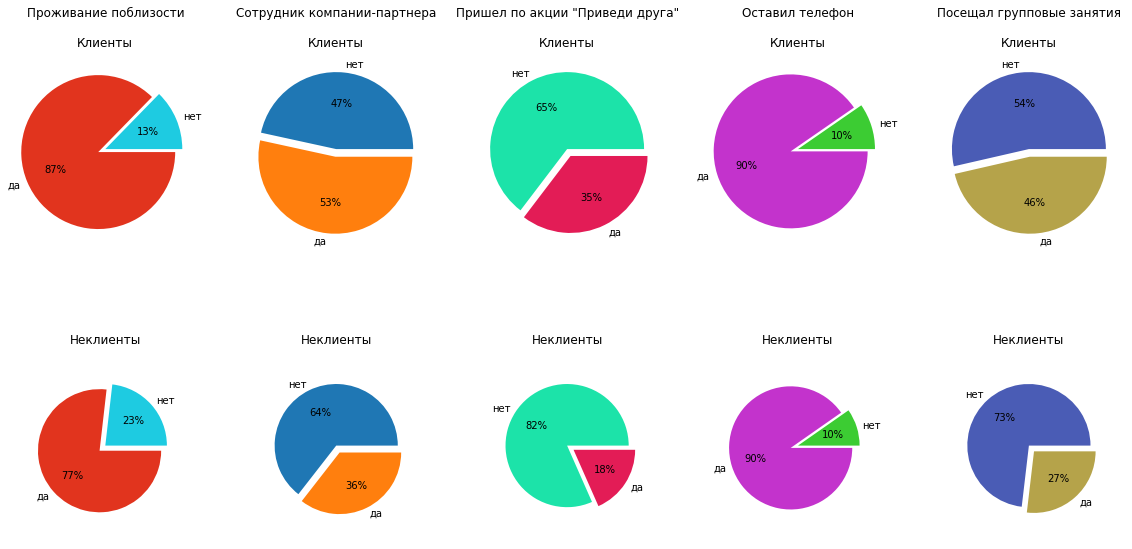

In [19]:
#Категорийные характеристики групп клиенты / неклиенты

fig, axs = plt.subplots(2, 5, figsize=(20,10))

# Проживание поблизости
axs[0, 0].pie(category_data_grouped['Near_location_in_0'], labels=category_data_grouped['Feature'], autopct='%.0f%%',
              explode=(0, 0.1), 
              colors=['#1ECBE1', '#E1341E'])
axs[0, 0].set_title('Проживание поблизости'+'\n'+'\n'+'Клиенты')
patches, texts, autotexts = axs[1, 0].pie(category_data_grouped['Near_location_in_1'], labels=category_data_grouped['Feature'],
                                          autopct='%.0f%%',
                                          explode=(0, 0.1), colors=['#1ECBE1', '#E1341E'], radius=0.8)
axs[1, 0].set_title('Неклиенты')

# Сотрудник компании-партнера
axs[0, 1].pie(category_data_grouped['Partner_in_0'], labels=category_data_grouped['Feature'], autopct='%.0f%%',
              explode=(0, 0.1))
axs[0, 1].set_title('Сотрудник компании-партнера'+'\n'+'\n'+'Клиенты')

patches, texts, autotexts = axs[1, 1].pie(category_data_grouped['Partner_in_1'], labels=category_data_grouped['Feature'],
                                           autopct='%.0f%%', radius=0.8,
                                           explode=(0, 0.1))
axs[1, 1].set_title('Неклиенты')

# Акция "Приведи друга"
axs[0, 2].pie(category_data_grouped['Promo_friends_in_0'], labels=category_data_grouped['Feature'], autopct='%.0f%%',
              explode=(0, 0.1), colors=['#1CE3A9', '#E31C56'])
axs[0, 2].set_title('Пришел по акции "Приведи друга"'+'\n'+'\n'+'Клиенты')

patches, texts, autotexts = axs[1, 2].pie(category_data_grouped['Promo_friends_in_1'], labels=category_data_grouped['Feature'],
                                           autopct='%.0f%%', radius=0.8,
                                           explode=(0, 0.1), colors=['#1CE3A9', '#E31C56'])
axs[1, 2].set_title('Неклиенты')

# Оставили телефон
axs[0, 3].pie(category_data_grouped['Phone_in_0'], labels=category_data_grouped['Feature'], autopct='%.0f%%',
              explode=(0, 0.1), colors=['#3CCC33', '#C333CC'])
axs[0, 3].set_title('Оставил телефон'+'\n'+'\n'+'Клиенты')

patches, texts, autotexts = axs[1, 3].pie(category_data_grouped['Phone_in_1'], labels=category_data_grouped['Feature'],
                                           autopct='%.0f%%', radius=0.8,
                                           explode=(0, 0.1), colors=['#3CCC33', '#C333CC'])
axs[1, 3].set_title('Неклиенты')

# Ходили на групповые занятия
axs[0, 4].pie(category_data_grouped['Group_visits_in_0'], labels=category_data_grouped['Feature'], autopct='%.0f%%',
              explode=(0, 0.1), colors=['#4A5CB5', '#B5A34A'])
axs[0, 4].set_title('Посещал групповые занятия'+'\n'+'\n'+'Клиенты')

patches, texts, autotexts = axs[1, 4].pie(category_data_grouped['Group_visits_in_1'], labels=category_data_grouped['Feature'],
                                           autopct='%.0f%%', radius=0.8,
                                           explode=(0, 0.1), colors=['#4A5CB5', '#B5A34A'])
axs[1, 4].set_title('Неклиенты')

plt.show()

__Проживание поблизости:__ действительно, среди группы неклиенты выше доля тех, кто проживает далеко от фитнес-центра (23% против 13% в группе "клиенты").  
__Сотрудник компании-партнера:__ среди клиентов - чуть больше половины, 53% - сотрудники компании-партнера, а среди неклиентов - только 1/3 является сотрудником компании-партнера.  
__Акция "Приведи друга":__ среди "клиентов" доля тех, кто пришел в рамках акции, в два раз выше, чем среди неклиентов и составляет 35% от количества человек в группе.  
__Оставили телефон__ одинаковое количество человек в двух группах - 10%.  
__Посещение групповых занятий:__ среди клиентов групповые занятия посещали почти половина группы, 46%, а среди тех, кто перестал ходить в фитнес-центр - только 27%.


### Количественные признаки

In [20]:
features = ['Age', 'Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_total',\
            'Avg_class_frequency_current_month', 'Avg_additional_charges_total']

In [21]:
#Я хотела посмотреть количество уникальных значений у признаков, чтобы прикинуть необходимое количество корзин
for i in features:
    print(data[i].nunique())

23
29
3
12
3913
3820
4000


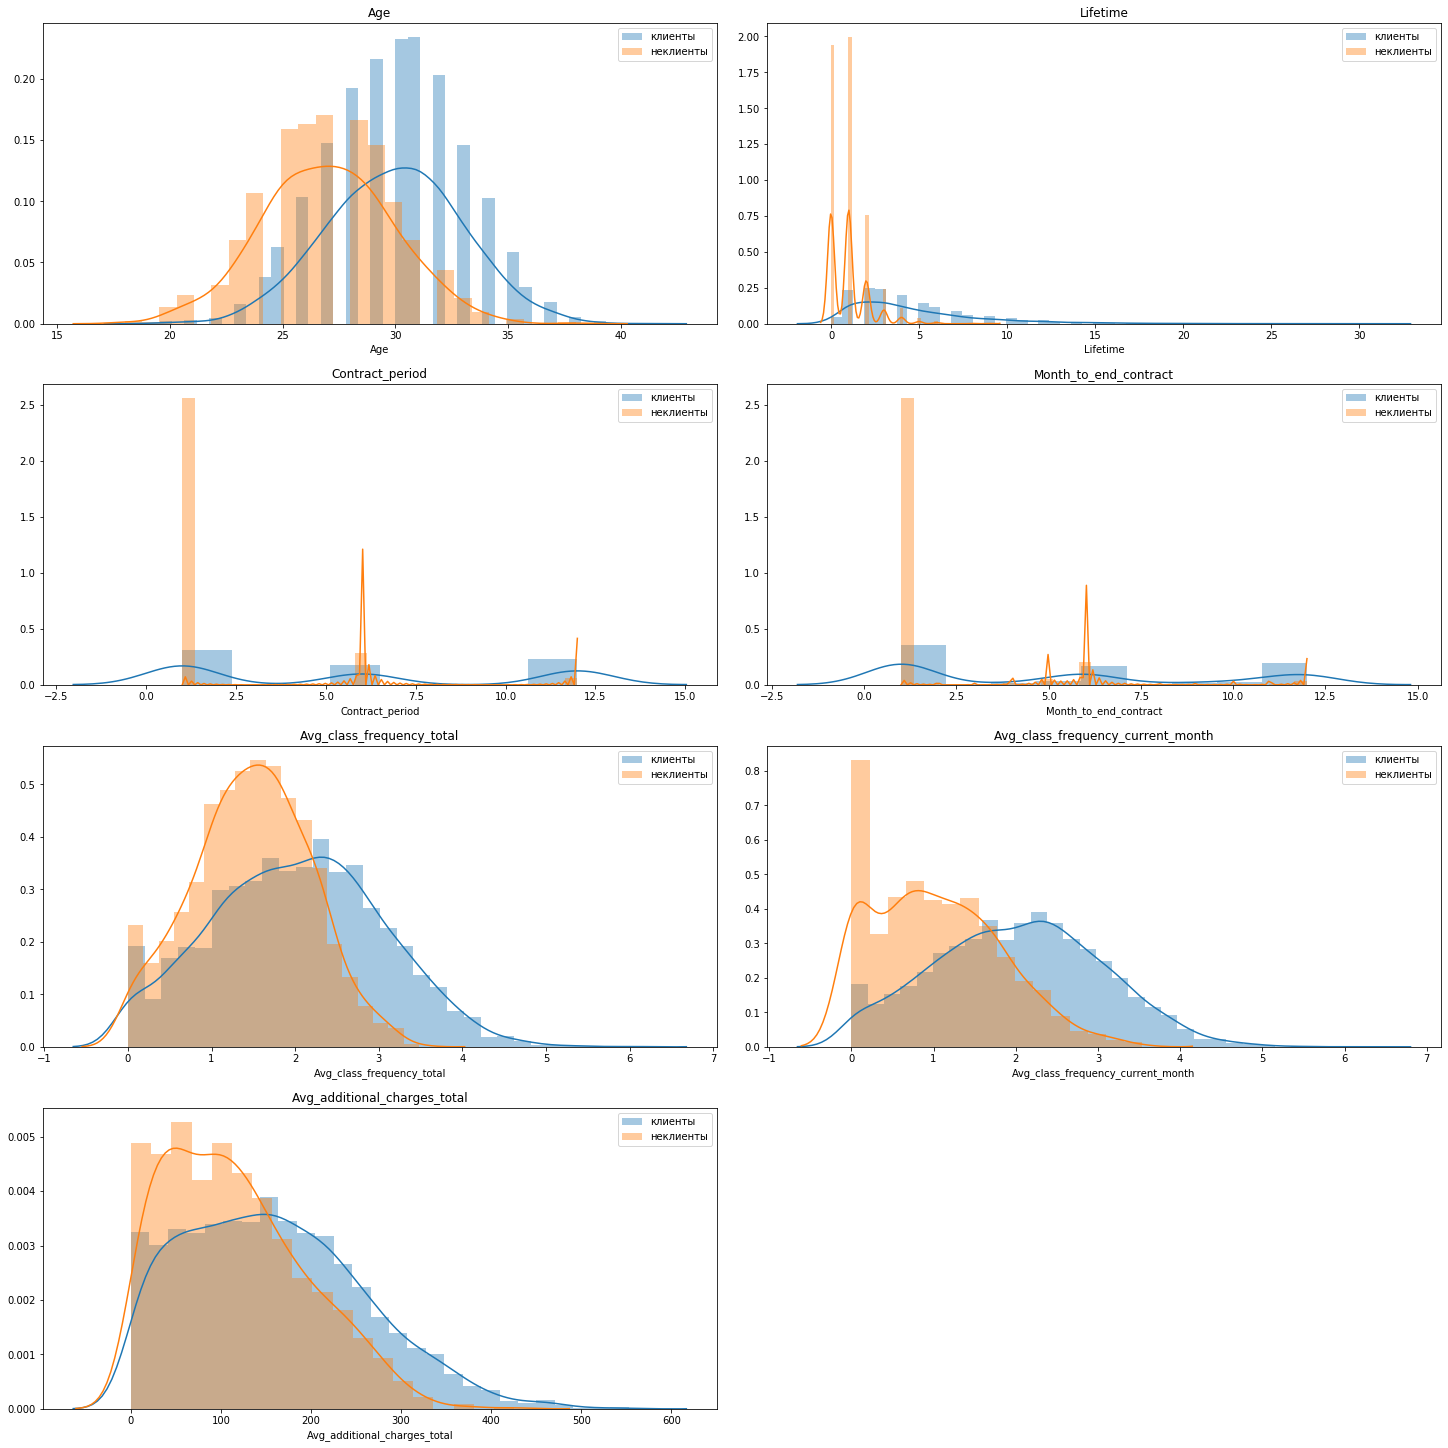

In [22]:
i = 0
fg = plt.figure(figsize=(20, 20), constrained_layout=True)
gs = fg.add_gridspec(4, 2)
for m in range(4):
    for n in range(2):
        fg.add_subplot(gs[m, n])
        column = features[i]
        ax = sns.distplot(data[data['Churn'] == 0][column], label='клиенты')
        sns.distplot(data[data['Churn'] == 1][column], label='неклиенты', ax=ax)
        plt.legend()
        plt.title(column)
        i +=1
        if i == len(features):
            break
plt.show()

__Возраст__ клиентов несколько выше чем возраст неклиентов, больше всего клиентов в возрасте 29-31 лет, тогда как среди неклиентов максимум приходится на 25-30 лет.  

__Время с момента первого обращения__ выше у клиентов, очевидно, что оттко происходит преимуществено в первые 2-3 месяца.  

__Срок договора__ у клиентов может быть 3, 6 и 12 месяцев. Практически у всех, кто прекратил пользоваться услугами ФЦ, договор был на 3 месяца.  

__Месяцы до окончания срока действия договора:__ клиенты прекращают пользоваться услугами преимущественно когда до окончания срока действия договора остается 1 месяц. У тех, кто регулярно посещает ФЦ, до окончания договора остается 4-12 месяцев.  

За все время пользования услугами ФЦ, __среднее количество посещений__ у тех, кто затем перестал ходить, было ниже, чем у тех, кто продолжает.  

__Среднее количество посещений в последний месяц__ у неклиентов тоже ниже, чем у тех, кто продолжает ходить.  

Не совсем корректный показатель __суммарной выручки__ (следовало бы считать в среднем за месяц) показывает, что распределение выручки от клиентов более равномерно и включает более высокие суммы, чем от неклиентов.

### Корреляция между количественными признаками

In [23]:
correlation_data = data[['Churn', 'Age', 'Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_total',\
            'Avg_class_frequency_current_month', 'Avg_additional_charges_total']]

In [24]:
corr = correlation_data.corr()

corr.style.background_gradient(cmap='GnBu').set_precision(2)

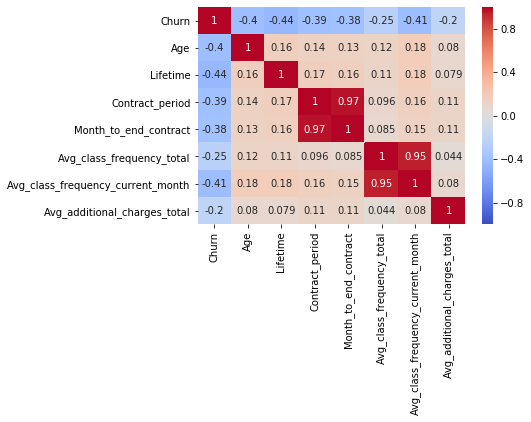

In [25]:
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap='coolwarm', annot=True)

Мы видим очень высокую корреляцию между:  
- "количеством месяцев в контракте" и "количеством месяцев до окончания договора", и в дальнейшем для обучения модели будем использовать только второй признак (как включающий бóльшее количество значений);  
- "средним количеством посещений за последний месяц" и "средним количеством посещений за все время договора". В данном случае я предпочту первый признак, так как он, на мой взгляд, лучше отражает настроение клиента касательно продолжения посещения ФЦ;  
- существует средняя отрицательная связь между показателем оттока и следующими показателями: Lifetime, Contract_period, Month_to_end_contract, Avg_class_frequency_current_month

In [26]:
data_model = data.drop(['Contract_period', 'Avg_class_frequency_total'], axis=1)
data_model.tail()

,Gender,Near_location,Partner,Promo_friends,Phone,Age,Lifetime,Month_to_end_contract,Group_visits,Avg_class_frequency_current_month,Avg_additional_charges_total,Churn
3995,1,1,1,0,1,33,8,12,0,2.349070,2.406023,0
3996,0,1,0,0,1,29,1,1,1,0.292859,68.883764,1
3997,1,1,1,1,1,28,2,11,0,2.831439,78.250542,0
3998,0,1,1,1,1,32,3,5,0,1.596237,61.912657,0
3999,1,0,1,0,0,30,1,12,1,1.035270,178.861814,0


## Кластеризация пользователей

На основе таблицы data_model (без 'Contract_period', 'Avg_class_frequency_total') создадим data_cluster для группировки пользователей.
Перед стандартизацией уберем столбец 'Churn'.

In [37]:
data_cluster = data_model.drop('Churn', axis=1)

In [38]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(data_cluster)

In [39]:
linked = linkage(x_sc, method = 'ward')

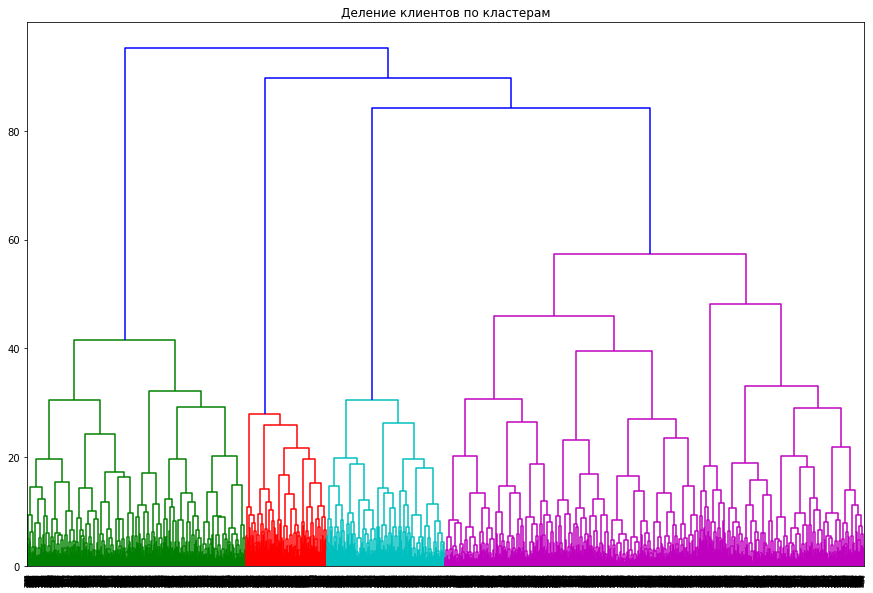

In [40]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Деление клиентов по кластерам')
plt.show()

Судя по визуализации матрицы расстояний между признаками имеет смысл выделить 4 кластера для расчета K-means.

In [41]:
km = KMeans(n_clusters = 4, random_state=11)
labels = km.fit_predict(x_sc)

Присваиваем номер кластера таблице data_model

In [42]:
data_model['Cluster'] = labels
data_model.head()

,Gender,Near_location,Partner,Promo_friends,Phone,Age,Lifetime,Month_to_end_contract,Group_visits,Avg_class_frequency_current_month,Avg_additional_charges_total,Churn,Cluster
0,1,1,1,1,0,29,3,5,1,0.000000,14.227470,0,1
1,0,1,0,0,1,31,7,12,1,1.910244,113.202938,0,3
2,0,1,1,0,1,28,2,1,0,1.736502,129.448479,0,3
3,0,1,1,1,1,33,2,12,1,3.357215,62.669863,0,2
4,1,1,1,1,1,26,3,1,0,1.120078,198.362265,0,2


In [43]:
means = data_model.groupby(['Cluster']).mean().reset_index()
means

,Cluster,Gender,Near_location,Partner,Promo_friends,Phone,Age,Lifetime,Month_to_end_contract,Group_visits,Avg_class_frequency_current_month,Avg_additional_charges_total,Churn
0,0,0.498221,0.000000,0.489324,0.078292,1.0,28.715302,3.056940,2.868327,0.236655,1.606120,137.388913,0.400356
1,1,0.523316,0.862694,0.471503,0.305699,0.0,29.297927,3.940415,4.466321,0.427461,1.723967,144.208179,0.266839
2,2,0.491393,0.996870,0.935055,0.755086,1.0,29.672926,4.646322,6.985915,0.508607,1.968245,158.398418,0.102504
3,3,0.524803,1.000000,0.166291,0.060316,1.0,28.956032,3.225479,2.833709,0.395152,1.682469,142.313871,0.339346


Прежде чем рассматривать количественные признаки, мы можем охарактеризовать категориальные:  
- __близость к ФЦ:__ если в 0-ю группу попали только те, кто живет далеко, то во 2-й и 3-й подавляющее большинство клиентов живут близко;  
- __сотрудник компании-партнера:__ во 2-й группе почти все относятся к этой категории, а в 3-й таких почти не встречается;  
- __пришли по акции "Приведи друга":__ во 2-й группе - те, кто воспользовались этой акцией, в 3-й таких практически нет;  
- __не оставляли телефон__ клиенты из 1-го кластера;  
- __групповые занятия__ посещала половина клиентов группы 2, в остальных группах доля таких клиентов ниже, но все же только в группе 0 она составляет менее 25%.

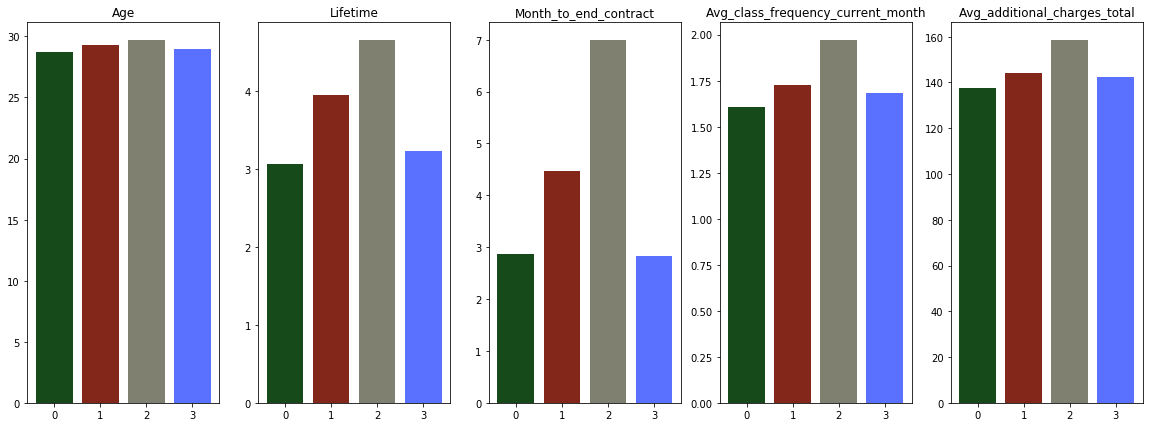

In [44]:
color_rectangle = np.random.rand(4, 3) 

fig, axs = plt.subplots(1, 5, figsize=(20,7), squeeze=False)
axs[0, 0].bar(means['Cluster'], means['Age'], color = color_rectangle)
axs[0, 0].set_title('Age')
axs[0, 1].bar(means['Cluster'], means['Lifetime'], color = color_rectangle)
axs[0, 1].set_title('Lifetime')
axs[0, 2].bar(means['Cluster'], means['Month_to_end_contract'], color = color_rectangle)
axs[0, 2].set_title('Month_to_end_contract')
axs[0, 3].bar(means['Cluster'], means['Avg_class_frequency_current_month'], color = color_rectangle)
axs[0, 3].set_title('Avg_class_frequency_current_month')
axs[0, 4].bar(means['Cluster'], means['Avg_additional_charges_total'], color = color_rectangle)
axs[0, 4].set_title('Avg_additional_charges_total')
plt.show()

Просматривая средние значения по кластерам, мы видим, что:  
__- средний возраст__ не меняется значительно от кластера к кластеру, но во 2-м кластере он самый высокий (названия кластеров - согласно их номерам в таблице);  
__- продолжительность__ пользования услугами самая высокая во 2-м кластере, самая низкая - в 0-вом и 3-м;  
__- срок до окончания контракта__ самый высокий во 2-й группе, самый низкий - в 0-й и 3-й;  
__- среднее количество посещений__ самое высокое во -2-й группе, самое низкое - в 0-й;  
__- средняя дополнительная выручка__ также выше всего во 2-й группе.

### Распределение признаков в кластерах

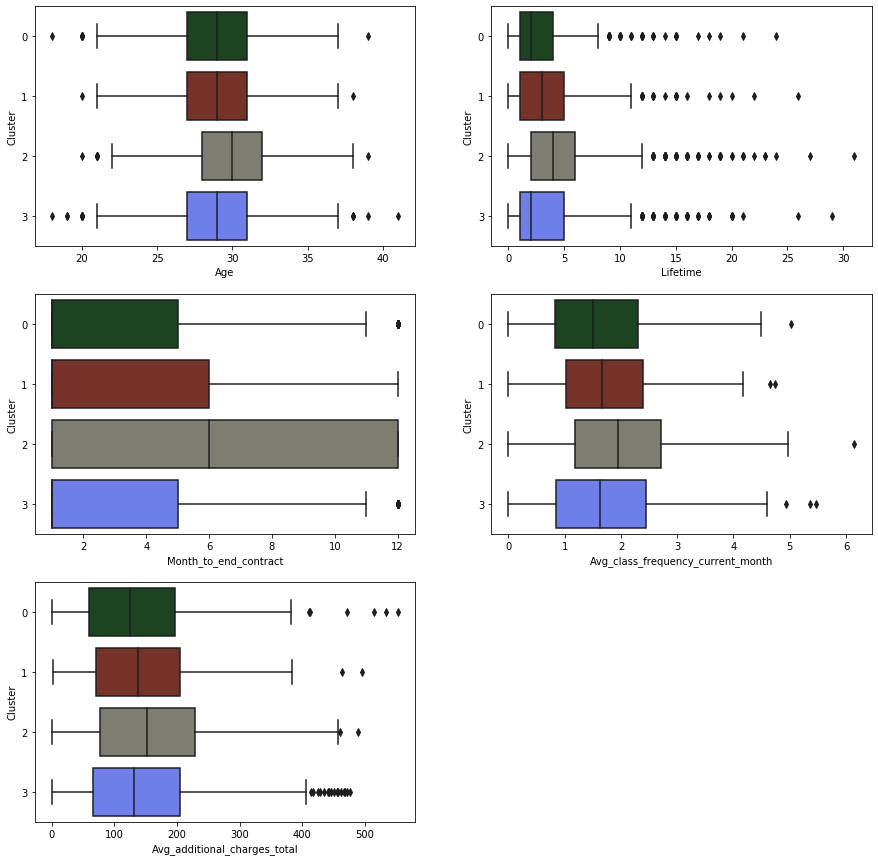

In [45]:
plt.subplots(figsize = (15, 15))

for i, param in enumerate(
    ['Age', 'Lifetime', 'Month_to_end_contract', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']):
    sns.boxplot(x=param, y = 'Cluster', data=data_model, palette=color_rectangle, orient='h', ax = plt.subplot(3,2,i+1))

Помимо различий в средних значениях признаков, по диаграмме размаха мы можем увидеть, что:  
- во 2-й группе - __наибольший размах значений времени пользования услугами__ ФЦ (lifetime), а в 1-й и 3-й группе большинство клиентов пользуются услугой недавно;  
- во 2-й группе __показатель количество месяцев до окончания контракта__ распределен более равномерно, чем в других группах;  
- во всех группах __некоторые клиенты не посещали ФЦ ни разу за последний месяц__, но во 2-й группе половина пользователей (2 и 3-й квартили) посещали ФЦ чаще, чем в других группах;  
- __суммарная выручка__ во 2-й группе выше, чем в других, причем мы помним, что, судя по матрице корреляций, размер выручки не коррелирует с длительностью пользования услугами.

### Доля оттока

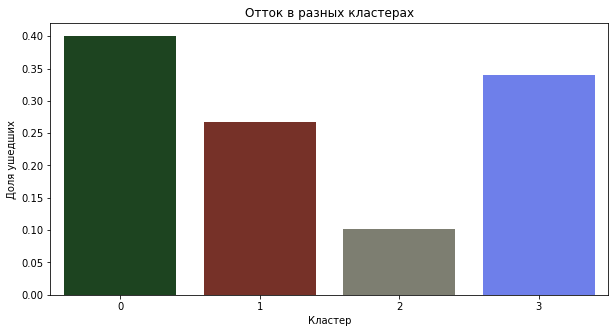

In [46]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Cluster', y='Churn', data=means, palette=color_rectangle)
plt.title('Отток в разных кластерах')
plt.xlabel('Кластер')
plt.ylabel('Доля ушедших')
plt.show()

Мы видим, что группы существенно отличаются по доле оттока: она минимальна в группе 2, максимальна - в 1-й.




## Основные выводы:

### Характеристика групп: 

__Группа 0:__ характеризуется максимальным показателем оттока. Обращают на себя внимание небольшой срок пользования услугами ФЦ, близость срока окончания действия контракта и значительной расстояние места проживания / работы от ФЦ.  
__Группа 1:__ 2-й минимальный показатель оттока. В этой группе объединены люди, не оставившие телефон, но, видимо, это не связано с другими показателями. Большинство клиентов этой группы живут близко от ФЦ, и 30-40% пользуются его услугами как сотрудники компании-партнера или пришли по акции от друга.  
__Группа 2:__ минимальный показатель оттока. Большинство живет/работает поблизости от ФЦ, длительное время пользуются его услугами.  
__Группа 3:__ высокий показатель оттока. Все живут/работают поблизости от ФЦ, но, в отличие от группы 1, пришли самостоятельно, а не по акциям. Также в отличие от группы 1, у клиентов этой группы довольно скоро заканчивается срок действия договора, в этом она схожа с группой 0.

### Рекомендации:
- необходимо увеличивать срок договора, предлагая его на 6 и 12 месяцев (видимо, делая более существенный разрыв между среднемесячной стоимостью договора при покупке карты на длительный срок);
- важно отслеживать близость окончания срока действия договора и предлагать продлить его заранее;
- продумать политику удержания постоянных клиентов - они меньше склонны уходить в отток;
- расширять список компаний-партнеров, их клиенты менее склонны уходить в отток; 
- в группе 3 активней информировать об акции "Приведи друга", она помогает повысить лояльность вновь пришедших;
- стимулировать регулярную посещаемость.

